# DSE 207R FINAL PROJECT
## Fall 2023
### Christopher Merry
### Due Date:  December 12th, 2023

Associated video, datasets, and supporting images are available at https://github.com/christopher-merry/ucsd/tree/main/207/final

# Background
Historically, the game of baseball has been entrenched in statistical analysis.  Classic stats such as batting average and earned run average have been a part of the game from the beginning.  However, modern technology, introduced at the turn of the century, has taken the power of analysis to ever increasing heights.  In today's game, a combination of radar and high speed cameras provide three dimensional tracking capabilities for ball and player tracking in real time.

## Statcast Data
In professional baseball, data are gathered in two primary ways: human score keepers (called stringers) and through high speed cameras.  In reality, there are a number of vendors and methods that may be utilized to gather tracking information, but this project will focus on the way it is captured in Major League Baseball in 2023.  Currently, every MLB venue has a set of high speed cameras that generate 30+ frames per second.  HawkEye is currently the exclusive provider of this technology.  HawkEye captures the data and breaks them down into data points for each player, identifying locations on the body such as ear, shoulder, elbow, knees, etc.  For each point at each frame, an X, Y, Z coordinate set is obtained, with all references starting at the apex of home plate.  This stream of points can then be used to calculate any number of statistical metrics including distance traveled on a play, player sprint speed, and more.  

## Keeping Score
In addition to digital information, there are also human score keepers, known as Stringers, that are capturing game events using propietary MLB software.  Game events include everything from pitch results such as balls and strikes, to batter results such as hits and outs.  It is up to the Official Scorer and Stringer (sometimes this is the same individual) to determine how to classify a particular play.  A more controversial aspect of this process occurs when a batter hits the ball and a fielder misplays the fielding attempt.  This is recorded as an error.  

On an error, a batter is penalized in statistical values such as batting average (calculated as hits / at-bats); however, if that batter-runner ends up scoring, the pitcher is not penalized in calculating their earned run average (ERA; calculated as 9 * RUNS / INNINGS).  On the other hand, if the same play is ruled a hit, instead of an error, the batter is rewarded with an increased batting average, and potentially, the pitcher may suffer a higher ERA.  Therefore, on close or controversial calls, the judgement of the scorer may come into question.  In fact, this past season has featured many debates in media on consistency of error calls.

## Objectives
With those ideas in mind, the purpose of this project is an initial attempt to use a combination of tracking metrics and stringer input to help recommend whether or not an error should be assigned to the fielder using machine learning.  This is a real world problem in Major League Baseball, and the dataset has been compiled from 2023 regular season games.

1) Can we create a reasonably predictive algorithm for consistently classifying errors in a baseball game using a combination of scoring details and player and ball tracking metrics?

2) Are there particular features that are more influential in determining play classification?

3) What types of data, if any, are going to make error predictions less accurate or less reliable?  Can those features be evaluated to determine classification probability?

# The Data

## The Source
The data obtained for this project is accessible through public API endpoints, with permission from Major League Baseball; however, for the purpose of this project, I was able to query the data directly.  The actual details of the tables such as table and column names were modified, and some details in the queries were left out for security reasons.

### METRIC
This table contains a row for each metric collected on a play.  With over a billion rows, this table is one of the largest tables in the database.  To be fair, there other data sources gathering information such as skeletal data that far surpass this table in size, but in terms of relational tables, this is a big one.  The one aspect of *METRIC* that makes it somewhat unusual is the mix of column types.  Some columns are traditional scalar types such as character and numeric values, while others are JSON objects.  In fact, in the query below, there is an example of accessing a JSON attribute value (data->>'value').

### EVENT 
This table is used to stored injested data from the vendor.  The data is primarily stored as JSON and includes the original x, y, z coordinates for the position of the ball at the time of a hit.

### FIELDING
*FIELDING* is a table that contains a single row for each fielder movement associated with a play.  In our dataset, we are obtaining metrics related to the position and movement of third basemen on plays where the ball is hit to that fielder.

### ATBAT
*ATBAT* is a table that contains a single row for a plate appearance (time a batter goes up to bat).  In our dataset, we are obtaining metrics related to the movement and path the ball traveled off the bat.

In [301]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Dataset Compiliation

## Attempt 1
My first attempt involved gathering two csv files, one associated with fielding metrics and the other associated with batting metrics.  The data included all plays from 2023 regular season games where the type of hit was a ground ball, and the third baseman had a fielding opportunity.

### Query
The following queries were used

```
SELECT -- column list
FROM   fielding fc 
WHERE  -- filter conditions to limit the dataset to MLB regular season games in 2023
       -- Also include filters for ground balls where a fielder had a chance to make a play
```
```
SELECT -- column list
FROM   atbat fc 
WHERE  -- filter conditions to limit the dataset to MLB regular season games in 2023
       -- Also include filters for ground balls where a fielder had a chance to make a play
```

In [269]:
df_fielding = pd.read_csv('final/fielding_2023.csv')
df_atbat = pd.read_csv('final/at_bat_2023.csv')

In [3]:
df_fielding.head(10)

,play_id,fielder_position,error,throwing_error,distance_covered,throw_distance,is_ground_ball_status,fielder_burst_distance,fielder_reaction_distance,fielder_jump_distance,fielder_angle_to_ball,fielding_chance,play_out
0,1a6e01bc-7033-421c-9fc9-f5fe132f8508,5,0.0,0.0,NaN,NaN,True,NaN,NaN,NaN,NaN,0.0,1.0
1,2639924a-0827-4904-bc9f-af6a2389d7f5,5,0.0,0.0,NaN,112.351,True,17.720,3.038,19.494,86.262,1.0,1.0
2,2706ee84-1603-484b-830b-b8012eb4b3fa,5,0.0,0.0,NaN,105.099,True,17.774,3.288,18.938,51.354,1.0,1.0
3,390ce2aa-26a6-47e1-ab3b-578d404c15ef,5,0.0,0.0,NaN,NaN,True,NaN,NaN,NaN,NaN,0.0,1.0
4,3c133e1f-b9a0-420f-abe1-157886e69f35,5,0.0,0.0,NaN,NaN,True,NaN,NaN,NaN,1.326,0.0,1.0
5,3eb3beb8-9e10-4e98-80d4-1e77362027dd,5,0.0,0.0,NaN,NaN,True,NaN,NaN,NaN,-51.399,0.0,0.0
6,4011e0d1-71cc-48a2-a88f-d5119ff2edfc,5,0.0,0.0,NaN,NaN,True,NaN,NaN,NaN,63.764,0.0,0.0
7,464311fc-bdb4-47e3-82f8-ee6261dd0c8b,5,0.0,0.0,NaN,NaN,True,NaN,NaN,NaN,64.616,0.0,1.0
8,5a06bb28-a0bb-47fb-9702-1aa34a60ad06,5,0.0,0.0,NaN,NaN,True,NaN,NaN,NaN,NaN,0.0,0.0
9,6735858a-0471-42a4-a1bb-d6f591301494,5,0.0,0.0,NaN,NaN,True,NaN,NaN,NaN,NaN,0.0,1.0


In [4]:
df_atbat.head(10)

,play_id,exit_velocity,launch_angle,launch_spin_rate,barrel
0,8a725e0a-e547-464f-873c-7dea02baf61c,93.831892,-5.628950,1071.190687,NaN
1,354d75fe-1624-4f4a-960e-aee2f74b5790,76.016227,9.562192,2754.615555,NaN
2,21590227-4e74-4428-97fd-ca636fe6b198,89.728378,-9.091950,2443.423586,NaN
3,28fb7fb7-aa98-4de1-8f27-d4b4360f7788,64.914426,-24.833305,7963.212014,NaN
4,8d6ec4f4-33f2-41cc-bb4b-612fd4e1a6e9,87.169399,-12.655816,3253.462090,NaN
5,f282f83f-4960-470a-8e91-a10e1f7f02e7,58.915142,-65.014628,5141.264860,NaN
6,92c88d48-680c-4050-8d98-74a1ccb4994d,41.439837,-44.441430,7176.720911,NaN
7,f2965f5c-d386-48db-9220-b8079ce523d0,73.029033,12.600537,667.873032,NaN
8,52b0f9f0-4400-4f3d-949c-980c35600b1e,104.404516,-5.989652,3977.036996,NaN
9,e487c33b-63ae-4c36-8324-3a658524ad23,100.072526,-12.374791,5519.765707,NaN


In [5]:
print(df_fielding.describe())
print(df_atbat.describe())

       fielder_position         error  throwing_error  distance_covered  \
count           53534.0  53494.000000    53494.000000        602.000000   
mean                5.0      0.008393        0.004337          6.860013   
std                 0.0      0.091231        0.065713          4.559146   
min                 5.0      0.000000        0.000000          3.001000   
25%                 5.0      0.000000        0.000000          4.162000   
50%                 5.0      0.000000        0.000000          5.536500   
75%                 5.0      0.000000        0.000000          7.437250   
max                 5.0      1.000000        1.000000         34.843000   

       throw_distance  fielder_burst_distance  fielder_reaction_distance  \
count    10042.000000            11389.000000               11389.000000   
mean       100.429326               17.499806                   6.774296   
std         26.652500                8.085984                   3.038413   
min          0.00000

In [6]:
print(df_fielding.shape)
print(df_atbat.shape)

(53534, 13)
(53494, 5)


In [7]:
print(df_fielding.info())
print(df_atbat.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53534 entries, 0 to 53533
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   play_id                    53534 non-null  object 
 1   fielder_position           53534 non-null  int64  
 2   error                      53494 non-null  float64
 3   throwing_error             53494 non-null  float64
 4   distance_covered           602 non-null    float64
 5   throw_distance             10042 non-null  float64
 6   is_ground_ball_status      53534 non-null  bool   
 7   fielder_burst_distance     11389 non-null  float64
 8   fielder_reaction_distance  11389 non-null  float64
 9   fielder_jump_distance      11389 non-null  float64
 10  fielder_angle_to_ball      23644 non-null  float64
 11  fielding_chance            53494 non-null  float64
 12  play_out                   53494 non-null  float64
dtypes: bool(1), float64(10), int64(1), object(1)
m

In [82]:
print(df_fielding.isnull().sum())
print(df_atbat.isnull().sum())

play_id                          0
fielder_position                 0
error                           40
throwing_error                  40
distance_covered             52932
throw_distance               43492
is_ground_ball_status            0
fielder_burst_distance       42145
fielder_reaction_distance    42145
fielder_jump_distance        42145
fielder_angle_to_ball        29890
fielding_chance                 40
play_out                        40
dtype: int64
play_id                 0
exit_velocity         300
launch_angle          211
launch_spin_rate      290
barrel              53492
dtype: int64


#### percent_nulls
Displays the number of NULL values in a column and presents the value as a percentage of the rows

In [183]:
def percent_nulls(df, col):
    null_count = df[col].isna().sum()
    not_null_count = df[col].count()
    total_count = null_count + not_null_count
    null_pct = float(null_count) / float(total_count)

    if null_count == 0:
        print(f"{col} has no null values")
    else: 
        print(f"{col} has {null_count} nulls out of {total_count} ({null_pct:.0%})")

In [10]:
for col in df_fielding.columns:
    percent_nulls(df_fielding, col)

play_id has no null values
fielder_position has no null values
error has 40 nulls out of 53534 (0%)
throwing_error has 40 nulls out of 53534 (0%)
distance_covered has 52932 nulls out of 53534 (99%)
throw_distance has 43492 nulls out of 53534 (81%)
is_ground_ball_status has no null values
fielder_burst_distance has 42145 nulls out of 53534 (79%)
fielder_reaction_distance has 42145 nulls out of 53534 (79%)
fielder_jump_distance has 42145 nulls out of 53534 (79%)
fielder_angle_to_ball has 29890 nulls out of 53534 (56%)
fielding_chance has 40 nulls out of 53534 (0%)
play_out has 40 nulls out of 53534 (0%)


In [12]:
for col in df_atbat.columns:
    percent_nulls(df_atbat, col)

play_id has no null values
exit_velocity has 300 nulls out of 53494 (1%)
launch_angle has 211 nulls out of 53494 (0%)
launch_spin_rate has 290 nulls out of 53494 (1%)
barrel has 53492 nulls out of 53494 (100%)


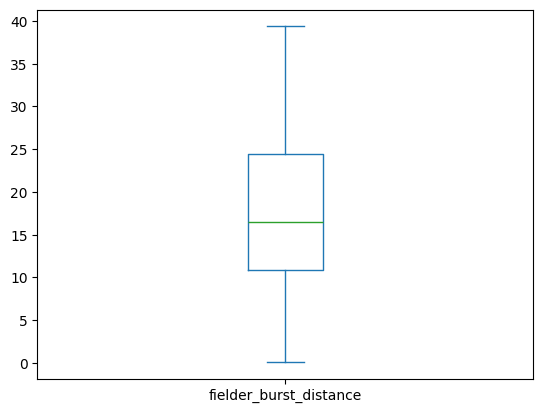

In [13]:
box = df_fielding['fielder_burst_distance'].plot.box()
plt.show()

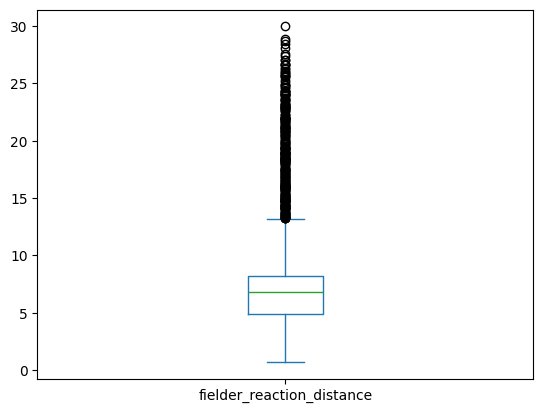

In [14]:
box = df_fielding['fielder_reaction_distance'].plot.box()
plt.show()

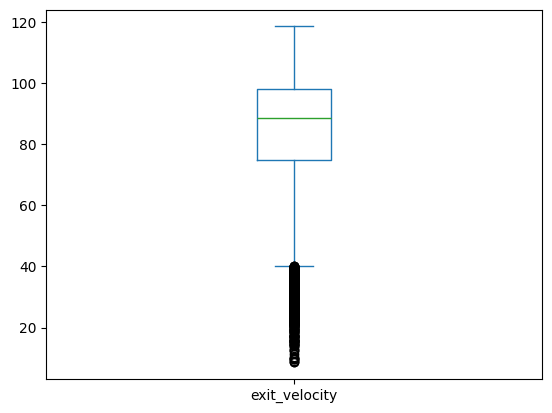

In [59]:
box = df_atbat['exit_velocity'].plot.box()
plt.show()

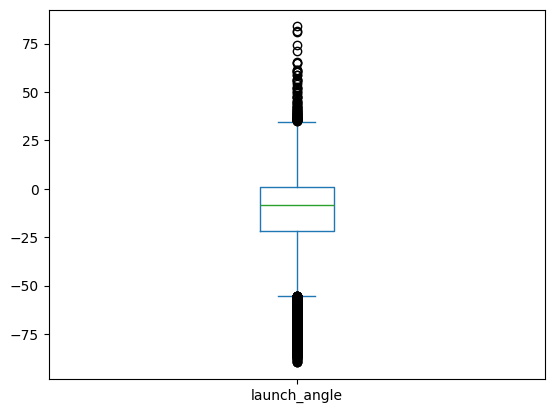

In [60]:
box = df_atbat['launch_angle'].plot.box()
plt.show()

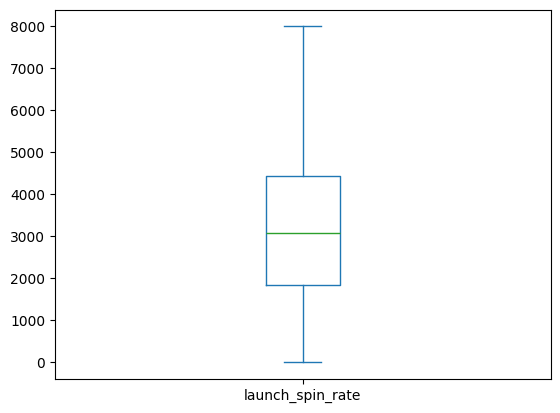

In [61]:
box = df_atbat['launch_spin_rate'].plot.box()
plt.show()

Change outlier values to NaN

In [270]:
df_fielding['fielder_burst_distance'] = np.where(
    df_fielding['fielder_burst_distance'] > 50, 
    np.nan, 
    df_fielding['fielder_burst_distance']
)

Remove the column fielder_reaction_distance

In [271]:
df_fielding.drop('fielder_reaction_distance', axis=1, inplace=True)

In [272]:
joined_df = df_fielding.merge(df_atbat, how='inner', on='play_id')
joined_df.head(10)

,play_id,fielder_position,error,throwing_error,distance_covered,throw_distance,is_ground_ball_status,fielder_burst_distance,fielder_jump_distance,fielder_angle_to_ball,fielding_chance,play_out,exit_velocity,launch_angle,launch_spin_rate,barrel
0,d061029e-a405-4e21-91a5-ff5936ad8e7c,3,0,0,NaN,67.390,True,NaN,NaN,-63.840,1,1,43.056180,-30.708741,2032.783214,NaN
1,d061029e-a405-4e21-91a5-ff5936ad8e7c,4,0,0,NaN,33.661,True,29.724,34.047,38.070,1,1,43.056180,-30.708741,2032.783214,NaN
2,73a684cb-1c3d-440b-9ff9-99cec48e2c12,3,0,0,NaN,NaN,True,NaN,NaN,-26.101,1,1,87.615494,-3.810183,5929.797200,NaN
3,73a684cb-1c3d-440b-9ff9-99cec48e2c12,6,0,0,NaN,112.848,True,10.496,14.026,-52.716,1,1,87.615494,-3.810183,5929.797200,NaN
4,341e72af-9634-439f-8e2d-62e53c97a78d,1,0,0,NaN,NaN,True,29.363,32.783,89.129,1,1,42.298880,-40.892292,3521.018495,NaN
5,f13b6c14-2077-4900-a346-3995a77ef65b,3,0,0,NaN,39.385,True,NaN,NaN,11.650,1,1,91.080303,-33.145256,4551.046012,NaN
6,f13b6c14-2077-4900-a346-3995a77ef65b,6,0,0,NaN,91.408,True,23.657,27.478,50.722,1,1,91.080303,-33.145256,4551.046012,NaN
7,fb7847db-a612-4dc6-adee-e03becc60ba2,3,0,0,NaN,56.062,True,20.339,24.744,12.488,1,1,66.313769,-36.234697,3553.298376,NaN
8,b6df83b1-a0a4-41fe-bbec-178d59ae836f,3,0,0,NaN,71.879,True,NaN,NaN,22.796,1,1,66.022891,-78.212933,6781.354954,NaN
9,b6df83b1-a0a4-41fe-bbec-178d59ae836f,2,0,0,NaN,78.594,True,21.226,22.680,NaN,1,1,66.022891,-78.212933,6781.354954,NaN


### Remove NaN
Since there are a few features with NULL values, we will fill in the unknows with the column mean.  This was done to ensure later algorithms did not have to deal with NULL values.

In [281]:
for col in joined_df.columns:
    if joined_df[col].dtype.kind in 'bifc': 
        joined_df[col].fillna(joined_df[col].mean(), inplace=True)

In [282]:
metrics = joined_df[[
    'fielder_burst_distance', 
    'fielder_jump_distance', 
    'fielder_angle_to_ball', 
    'exit_velocity', 
    'launch_angle', 
    'launch_spin_rate',
    'play_out',
    'error'
]]

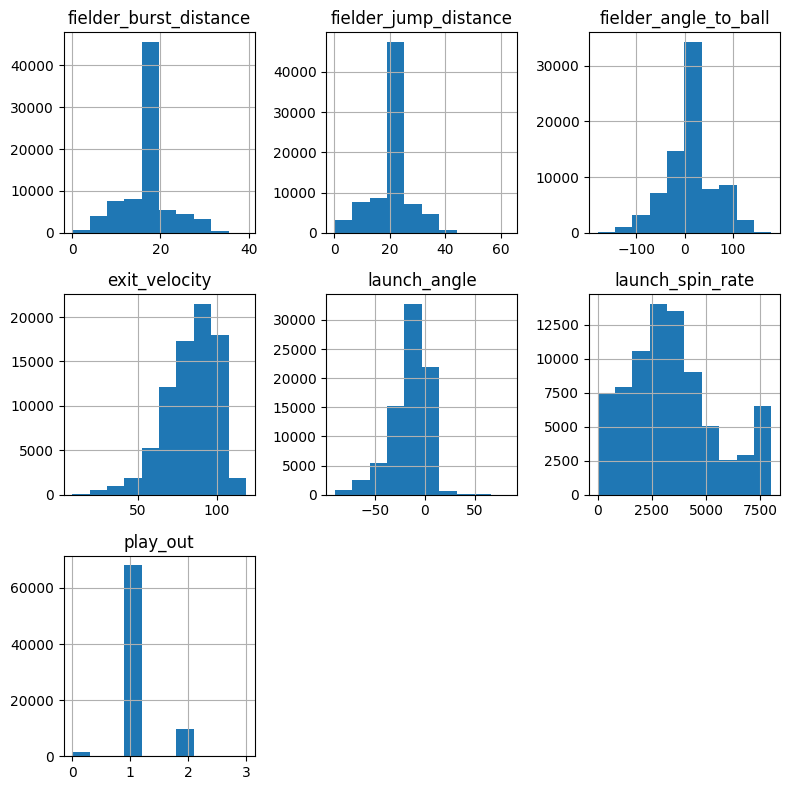

In [283]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

i = 0
for col in metrics.columns:
    if i < 7:
        ax = axes[i // 3, i % 3]
        metrics[col].hist(ax=ax, bins=10)
        ax.set_title(col)
        i+=1

fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])

plt.tight_layout()
plt.show()

In [295]:
x_data = metrics[['fielder_burst_distance', 
    'fielder_jump_distance', 
    'fielder_angle_to_ball', 
    'exit_velocity', 
    'launch_angle', 
    'launch_spin_rate',
    'play_out'
]]
y_target = metrics['error']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_target, test_size=0.2, random_state=32)

In [285]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(63668, 7)
(15918, 7)
(63668,)
(15918,)


Encountered an error with Logistic Regression, and the error message recommended using preprocessing standard scaler

In [288]:
scaler = preprocessing.StandardScaler().fit(x_train)
x_scaled = scaler.transform(x_train)

In [297]:
# Create an instance of the model
logmodel = LogisticRegression()

# Fit the model to the training data
logmodel.fit(x_scaled, y_train)

# Use the model to predict the test set results
y_pred = logmodel.predict(x_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print("Model Accuracy: ", accuracy)

Model Accuracy:  0.022867194371152155


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


The poor accuracy of Logistic Regression led me to try Random Forest Classifier

In [299]:
# Create an instance of the RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100) # You can adjust the number of trees

# Fit the model to the training data
rfc.fit(x_train, y_train)

# Use the model to predict the test set results
y_pred = rfc.predict(x_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print("Model Accuracy: ", accuracy)

Model Accuracy:  0.9979268752355823


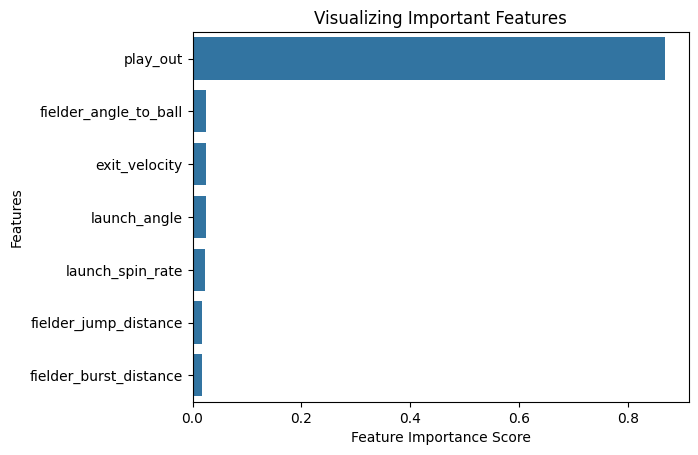

In [300]:
feature_imp = pd.Series(rfc.feature_importances_,index=x_data.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features')
plt.show()

The visual above indicates too much importance being placed on the 'PLAY_OUT' feature.  This column closely mimics the 'ERROR' column, which is used for training.  This led to overfitting in the prediction algorithm.

<Axes: >

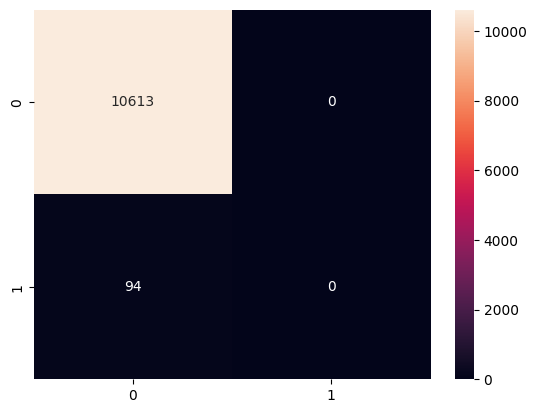

In [77]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

With no predicted errors, this attempt definitely has a flaw somewhere in the algorithm.  Between NaN values and the inclusion of PLAY_OUT, this attempt definitely has several issues to resolve.

### Findings
After evaluating the dataset, I realized too many features had significantly high NULL counts.  I decided to forego this dataset and focus on features with more defined values.   

## Attempt 2
### Query
My next attempt featured a query that generated a single CSV file.  While our database holds baseball data for a variety of levels and leagues, this dataset only contains Major League Baseball regular season games played in the month of July 2023.  In addition, a specific set of potentially relavent metrics are being returned, but only for the position of third base.  Fielding rows are being joined to the metric table via an inner join and further by rows where the player had a chance to make the play.  Finally, batting metrics are joined to the other tables to provide the full dataset.

One interesting approach used by this query turned multiple metric rows into a single row by using a combination of the MAX aggregate function, along with the GROUP BY clause.  This technique, in effect, creates a pivot table of sorts.

```
SELECT -- column list
       -- Example of how I pivot the data from rows to columns
       MAX(CASE WHEN id = 123 THEN value END) AS fielding_sprint_speed, 
FROM   metric gp 
JOIN   atbat ab
ON     gp.id = ab.id 
AND    gp.play = ab.play 
JOIN   fielding f 
ON     gp.id = f.id 
AND    gp.play = f.play 
AND    gp.position = f.position 
WHERE  -- include filtering for MLB games in July 2023
       -- limit the rows to third basemen only
GROUP BY -- non aggregate columns;
```

In [174]:
df = pd.read_csv('final/207_data_202307.csv')

In [175]:
df.head(10)

,game_id,play_id,play_out,reached_base_on_error,error,fielding_chance,launch_angle,exit_velocity,fielder_angle,fielder_distance,fielder_burst_distance,fielder_reaction_distance,fielder_routing_distance,fielder_jump_distance,start_player_angle,end_player_angle,start_player_position,end_player_position,fielding_zone
0,717179,17996645-7e9d-40fa-bdca-2fe01492aa0d,1,0,0,1,-25.597094,90.593521,-131.068,18.240,12.379,3.127,3.424,11.906,-36.945,-36.942,132.524,132.523,Back
1,717179,213f2fa4-a566-40ab-9fbc-daeb9fc80f2d,2,0,0,1,-15.819751,78.084128,135.066,58.759,26.435,7.088,1.792,31.271,-34.277,-34.259,108.815,108.801,Standard Back
2,717179,4b32275d-b608-449e-aa80-4f5e468ff263,1,0,0,1,-14.555188,97.876350,NaN,6.198,9.496,2.191,2.206,9.348,-34.685,-34.692,121.821,121.790,Standard Back
3,717179,4c7088d4-7f8e-4f9a-b829-1807e6d32ccc,2,0,0,1,-4.060342,102.033881,-31.363,51.528,19.916,7.950,1.387,26.045,-34.680,-34.706,121.618,121.580,Standard Back
4,717179,5e2cfe93-a0b3-422f-8247-3b83f301106e,1,0,0,1,3.354306,41.104402,-11.242,70.170,24.328,7.182,1.331,29.752,-27.267,-27.662,113.729,113.133,Standard Back
5,717179,8edb7f12-0b80-4ecd-93ff-1ff9e3416c8c,0,0,1,1,NaN,NaN,15.322,26.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,717179,b8c18a0f-4514-402c-a722-0ee3525118bc,1,0,0,1,-8.362124,89.873971,-12.284,16.852,11.730,7.745,2.894,16.115,-36.495,-36.468,132.693,132.718,Back
7,717179,d01ce028-9ab4-4738-85b2-cff73366946f,1,0,0,1,68.865269,88.098835,NaN,NaN,2.082,0.905,1.613,1.363,-36.589,-40.541,132.302,138.122,Back
8,717179,dbbbba85-3af7-41c2-8958-f0b0aa665bd5,1,0,0,1,-11.182198,52.660833,39.524,23.502,17.020,5.508,1.774,20.369,-21.943,-21.929,130.269,130.253,Back
9,717179,fd4198db-44f2-4665-9520-203970d5c59f,1,0,0,1,-32.705682,84.560716,60.946,69.684,22.857,7.209,1.001,28.597,-36.703,-36.702,130.953,130.948,Back


Describing only the numeric features of the dataframe.  It looks like *fielder_distance* may have a significant outlier based on the 25% percent and MIN values.

In [176]:
df[[
    'launch_angle', 
    'exit_velocity', 
    'fielder_angle', 
    'fielder_distance', 
    'fielder_burst_distance', 
    'fielder_reaction_distance',
    'fielder_routing_distance', 
    'fielder_jump_distance',
    'start_player_angle',
    'start_player_position',
    'end_player_angle',
    'end_player_position'
]].describe()

,launch_angle,exit_velocity,fielder_angle,fielder_distance,fielder_burst_distance,fielder_reaction_distance,fielder_routing_distance,fielder_jump_distance,start_player_angle,start_player_position,end_player_angle,end_player_position
count,1833.000000,1832.000000,1519.000000,1786.000000,1767.000000,1767.000000,1767.000000,1767.000000,1833.000000,1833.000000,1833.000000,1833.000000
mean,-1.371757,81.815023,42.101384,46.423189,17.722722,6.282167,2.883571,20.810936,-33.663001,118.822496,-36.115351,117.458679
std,34.581792,15.273442,64.777055,29.337210,7.933240,2.832115,1.920498,10.079223,5.162110,11.620118,8.634608,19.973591
min,-85.547845,17.021016,-176.204000,0.200000,0.631000,0.712000,0.403000,1.042000,-41.404000,53.089000,-91.543000,8.951000
25%,-23.449043,72.610375,-2.351000,22.871500,11.035500,4.374500,1.482000,12.509500,-37.147000,115.321000,-37.913000,113.613000
50%,-7.112647,83.328216,49.493000,41.719500,17.361000,6.267000,2.294000,20.469000,-35.561000,120.928000,-36.162000,120.482000
75%,6.800648,92.991970,94.196500,67.718750,24.691500,7.911000,3.689500,28.987500,-31.817000,125.262000,-34.051000,125.206000
max,84.175661,113.720113,177.719000,154.669000,34.884000,29.955000,14.420000,55.373000,-17.242000,148.084000,12.399000,208.736000


In [291]:
df.shape

(1837, 19)

In [292]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1837 entries, 0 to 1836
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   game_id                    1837 non-null   int64  
 1   play_id                    1837 non-null   object 
 2   play_out                   1837 non-null   int64  
 3   reached_base_on_error      1837 non-null   int64  
 4   error                      1837 non-null   int64  
 5   fielding_chance            1837 non-null   int64  
 6   launch_angle               1837 non-null   float64
 7   exit_velocity              1837 non-null   float64
 8   fielder_angle              1837 non-null   float64
 9   fielder_distance           1837 non-null   float64
 10  fielder_burst_distance     1837 non-null   float64
 11  fielder_reaction_distance  1837 non-null   float64
 12  fielder_routing_distance   1837 non-null   float64
 13  fielder_jump_distance      1837 non-null   float

## NULL Values
There are a few NULL values that will have to be addressed.  My initial pass included metrics with far more NULLs.  There were so many, in fact, that I created a function to inspect each feature and return a percentage.  In my first dataset, several metric values had 70% or more NULL values. This dataset seems much cleaner in respect to NaN values.

In [182]:
df.isnull().sum()

game_id                        0
play_id                        0
play_out                       0
reached_base_on_error          0
error                          0
fielding_chance                0
launch_angle                   4
exit_velocity                  5
fielder_angle                318
fielder_distance              51
fielder_burst_distance        70
fielder_reaction_distance     70
fielder_routing_distance      70
fielder_jump_distance         70
start_player_angle             4
end_player_angle               4
start_player_position          4
end_player_position            4
fielding_zone                  4
dtype: int64

In [184]:
for col in df.columns:
    percent_nulls(df, col)

game_id has no null values
play_id has no null values
play_out has no null values
reached_base_on_error has no null values
error has no null values
fielding_chance has no null values
launch_angle has 4 nulls out of 1837 (0%)
exit_velocity has 5 nulls out of 1837 (0%)
fielder_angle has 318 nulls out of 1837 (17%)
fielder_distance has 51 nulls out of 1837 (3%)
fielder_burst_distance has 70 nulls out of 1837 (4%)
fielder_reaction_distance has 70 nulls out of 1837 (4%)
fielder_routing_distance has 70 nulls out of 1837 (4%)
fielder_jump_distance has 70 nulls out of 1837 (4%)
start_player_angle has 4 nulls out of 1837 (0%)
end_player_angle has 4 nulls out of 1837 (0%)
start_player_position has 4 nulls out of 1837 (0%)
end_player_position has 4 nulls out of 1837 (0%)
fielding_zone has 4 nulls out of 1837 (0%)


The machine learning types I attempted would not work with the presence of NULL values.  I opted to fill missing values with the column mean value.

In [194]:
for col in df.columns:
    if df[col].dtype.kind in 'bifc': 
        df[col].fillna(df[col].mean(), inplace=True)

## Metrics Only
I created a new dataframe to contain only the metrics I thought might be influential in predicting errors.  After looking at the values in a boxplot, it appears most of the features contain outliers.  These outliers, as long as they are tracked correctly, are necessary.  For example, a 35mph exit velocity may be out of the norm, but it is definitely a reasonable value.  Although we do not see this, a negative exit velocity or a value extremely high would have been an example of bad tracking data, which does happen from time to time.  

In [187]:
box_metrics = df[[
    'launch_angle', 
    'exit_velocity', 
    'fielder_angle',
    'fielder_distance', 
    'fielder_burst_distance',
    'fielder_routing_distance',
    'fielder_jump_distance',
    'start_player_angle',
    'end_player_angle',
    'start_player_position',
    'end_player_position'
]]

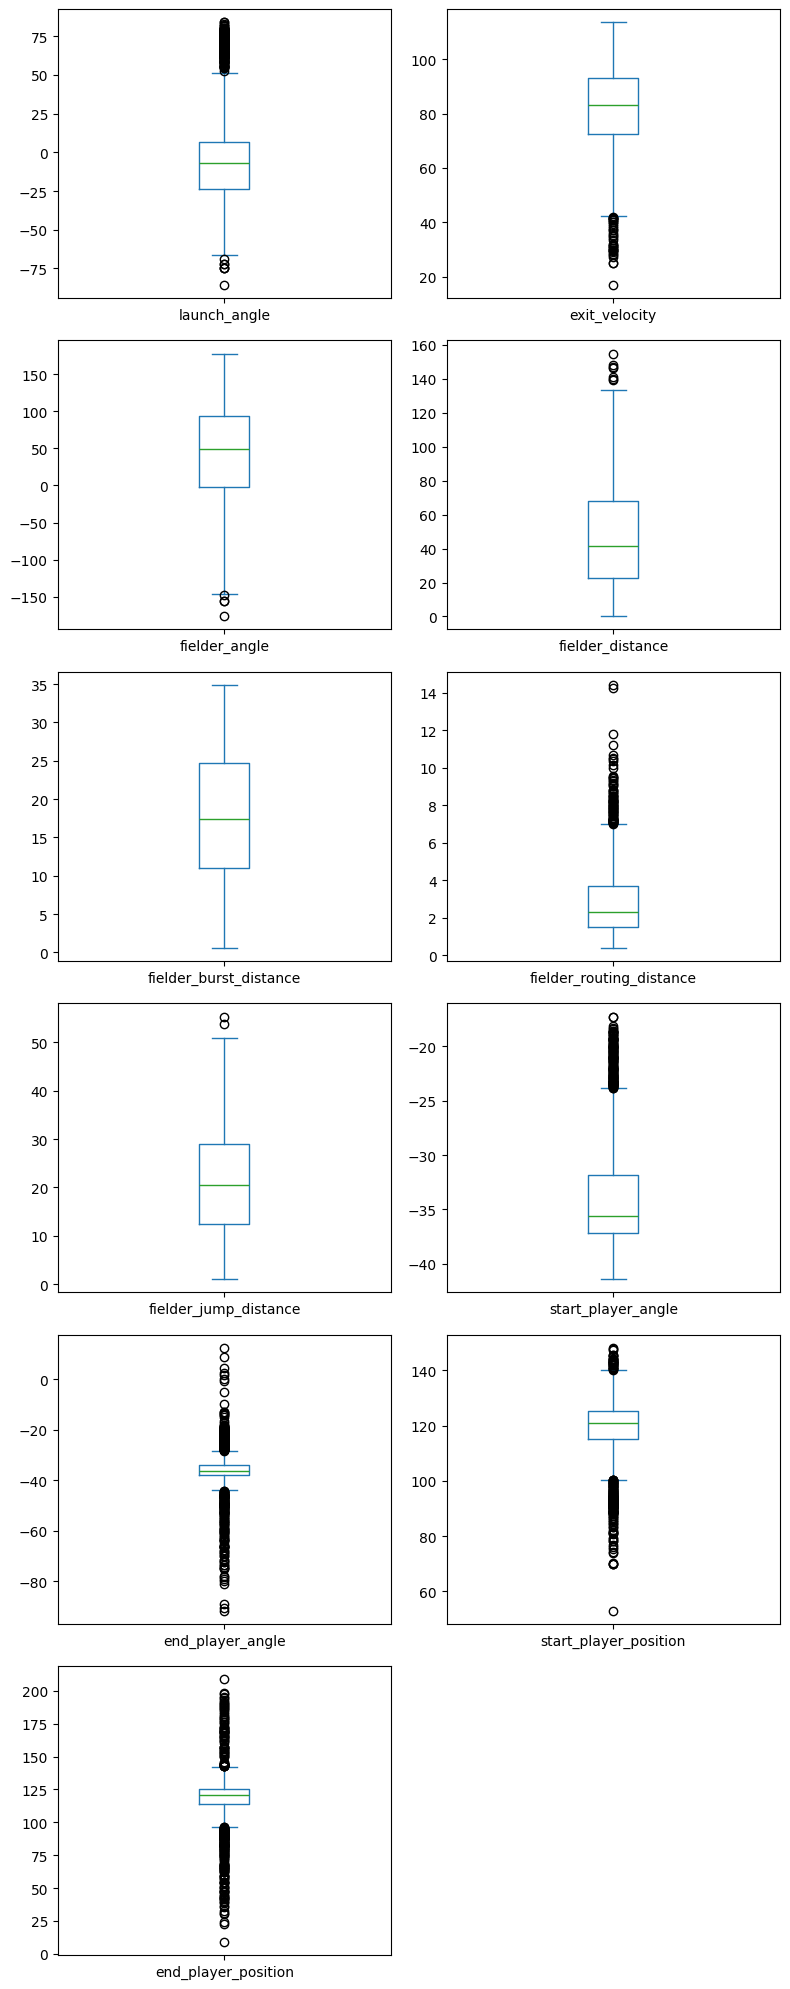

In [189]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(8, 20))

i = 0
for col in box_metrics.columns:
    x = i // 2
    y = i % 2
    ax = axes[x, y]
    box_metrics[col].plot.box(ax=ax)
    i+=1

plt.delaxes(axes[5, 1])
plt.tight_layout()
plt.show()

While there does appear to be some skewness to the features, *launch_angle* seems to be the only multimodel feature.

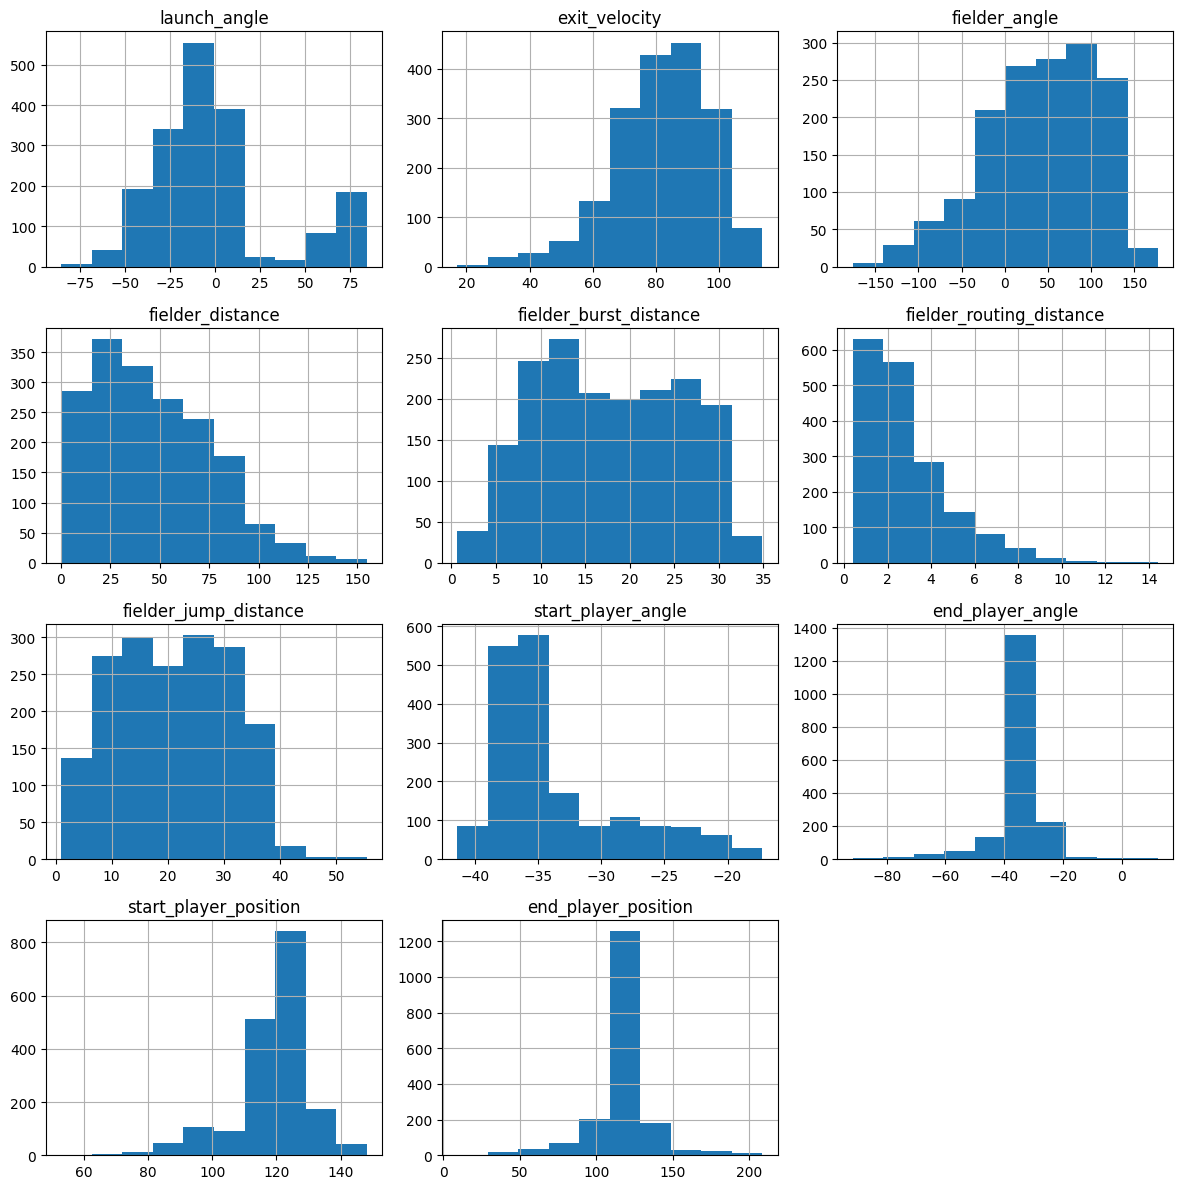

In [191]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

i = 0
for col in box_metrics.columns:
    ax = axes[i // 3, i % 3]
    box_metrics[col].hist(ax=ax, bins=10)
    ax.set_title(col)
    i+=1

plt.delaxes(axes[3, 2])

plt.tight_layout()
plt.show()

### Metric Explanations
#### Fielder Angle
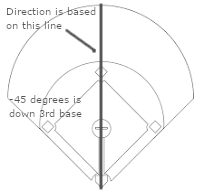

#### Launch Angle
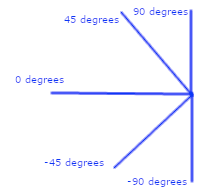

In [192]:
def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    
    return outliers

In [193]:
for col in box_metrics:
    outliers = find_outliers_IQR(df[col])
    print(f"{col}")
    print(f"number of outliers: {str(len(outliers))}")
    print(f"max outlier value: {str(outliers.max())}")
    print(f"min outlier value: {str(outliers.min())}")

launch_angle
number of outliers: 274
max outlier value: 84.175661
min outlier value: -85.547845
exit_velocity
number of outliers: 36
max outlier value: 42.004014
min outlier value: 17.021016
fielder_angle
number of outliers: 4
max outlier value: -147.955
min outlier value: -176.204
fielder_distance
number of outliers: 7
max outlier value: 154.669
min outlier value: 139.049
fielder_burst_distance
number of outliers: 0
max outlier value: nan
min outlier value: nan
fielder_routing_distance
number of outliers: 82
max outlier value: 14.42
min outlier value: 7.006
fielder_jump_distance
number of outliers: 2
max outlier value: 55.373
min outlier value: 53.882
start_player_angle
number of outliers: 147
max outlier value: -17.242
min outlier value: -23.816
end_player_angle
number of outliers: 367
max outlier value: 12.399
min outlier value: -91.543
start_player_position
number of outliers: 202
max outlier value: 148.084
min outlier value: 53.089
end_player_position
number of outliers: 291
max o

In [195]:
x_data = df[[
    'launch_angle', 
    'exit_velocity', 
    'fielder_angle',
    'fielder_distance', 
    'fielder_burst_distance',
    'fielder_routing_distance',
    'fielder_jump_distance',
    'start_player_angle',
    'end_player_angle',
    'start_player_position',
    'end_player_position',
    'play_out'
]]

y_target = df['error']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_target, test_size=0.2, random_state=32)

In [196]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1469, 12)
(368, 12)
(1469,)
(368,)


In [197]:
# Define the model
gb = GradientBoostingClassifier()

# Set up the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 4, 5]
}

# Implement GridSearchCV to search for the best parameters
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5)

# Fit the model to the training data
grid_search.fit(x_train, y_train)

# Print out the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best estimator to make predictions on the test set
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(x_test)

Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}


In [198]:
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy: ", accuracy)

Model Accuracy:  0.9972826086956522


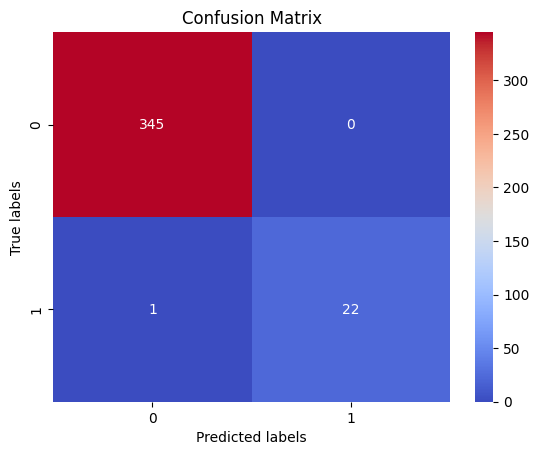

In [199]:
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

We see from the predicted vs actual heatmap, the algorithm correctly identified 345 plays where no error was made and 22 plays where an error was made.  There was one Type 2 Error on a play that the algorithm determined was not an error, but did was in fact scored an error.  As explained below, this actually turned out to be a flaw in training. 

The following code was used to find the single Type 1 Error, as well as find a sample row with a correct prediction of an error.

In [200]:
# Convert the test labels and predicted labels to pandas series
y_test_series = pd.Series(y_test.tolist(), name='Actual')
y_pred_series = pd.Series(y_pred.tolist(), name='Predicted')

# Concatenate the two series into a dataframe
compare_df = pd.concat([y_test_series, y_pred_series], axis=1)

# Find the false negatives
false_negatives = compare_df[(compare_df['Actual'] == 1) & (compare_df['Predicted'] == 0)]
true_positives = compare_df[(compare_df['Actual'] == 1) & (compare_df['Predicted'] == 1)]
random_true_positive_test_row = true_positives.sample(n=1)

# Now, let's find the original rows in the data
false_negatives_test_row = x_test.iloc[false_negatives.index]
true_positives_test_row = x_test.iloc[random_true_positive_test_row.index]

#Print the original rows
print(false_negatives_test_row)
print(true_positives_test_row)

      launch_angle  exit_velocity  fielder_angle  fielder_distance  \
1040    -54.949983      70.976709         25.774            88.461   

      fielder_burst_distance  fielder_routing_distance  fielder_jump_distance  \
1040                  29.279                     1.657                 33.754   

      start_player_angle  end_player_angle  start_player_position  \
1040             -39.632           -39.629                123.688   

      end_player_position  play_out  
1040              123.681         0  
     launch_angle  exit_velocity  fielder_angle  fielder_distance  \
235      1.553056       95.27297        -19.011            14.191   

     fielder_burst_distance  fielder_routing_distance  fielder_jump_distance  \
235                  11.071                     6.516                 11.629   

     start_player_angle  end_player_angle  start_player_position  \
235             -35.152           -35.249                 131.22   

     end_player_position  play_out  
235    

In [201]:
false_negative_original_row = df[(df['launch_angle'] == -54.949983) & (df['exit_velocity'] == 70.976709)]

false_negative_original_row

,game_id,play_id,play_out,reached_base_on_error,error,fielding_chance,launch_angle,exit_velocity,fielder_angle,fielder_distance,fielder_burst_distance,fielder_reaction_distance,fielder_routing_distance,fielder_jump_distance,start_player_angle,end_player_angle,start_player_position,end_player_position,fielding_zone
1040,717389,b63ee0a6-16d7-4650-a0e7-0ec4d56d10cf,0,0,1,1,-54.949983,70.976709,25.774,88.461,29.279,6.543,1.657,33.754,-39.632,-39.629,123.688,123.681,Standard Back


## False Negative

<video width="600px" height=" " 
       src="images/false_negative.mp4"  
       controls>
</video>

On this play, the official scorer credited the batter with a hit; however, the fielder's errant throw lead to the batter-runner advancing to second base.  In that situation, an error had to be made on the play to explain the runner advancement.  While this is a *false negative* based on our initial setup, this is really more of an issue with the test value.  The algorithm correctly gave the runner a base hit.  A more sophisiticated training value will be needed to account for this type of play.

## True Positive

<video width="600px" height=" " 
       src="images/true_positive.mp4"  
       controls>
</video>

This is an example of good test case.  The speed of the hit (95mph exit velocity) and time it takes for the camera to adjust to the fielder gives the impression that the ball was by the fielder before he could really react.  This is exactly the sort of play that would be great to standardize the call. Some scorers could give benefit of the doubt to the batter for a hard hit with solid contact.

In [202]:
la = true_positives_test_row['launch_angle'].values[0]
ev = true_positives_test_row['exit_velocity'].values[0]
true_positive_original_row = df[(df['launch_angle'] == la) & (df['exit_velocity'] == ev)]
true_positive_original_row

,game_id,play_id,play_out,reached_base_on_error,error,fielding_chance,launch_angle,exit_velocity,fielder_angle,fielder_distance,fielder_burst_distance,fielder_reaction_distance,fielder_routing_distance,fielder_jump_distance,start_player_angle,end_player_angle,start_player_position,end_player_position,fielding_zone
235,717227,49263ffe-dbde-4702-9e2f-bf2207654f03,0,1,1,1,1.553056,95.27297,-19.011,14.191,11.071,7.497,6.516,11.629,-35.152,-35.249,131.22,130.96,Back


# Early Failed Attempts

## Overfit

In [110]:
svc = svm.SVC(probability=True)
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}])

In [111]:
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'C': 1, 'kernel': 'linear'}
Best score found:  0.9972719463211905


In [112]:
y_pred = grid_search.predict(x_test)

In [113]:
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy: ", accuracy)

Model Accuracy:  1.0


<Axes: >

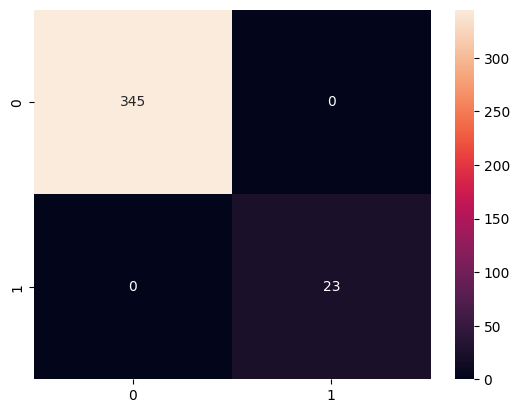

In [114]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

## Poor Accuracy

In [96]:
# Create an instance of the model
logmodel = LogisticRegression()

# Fit the model to the training data
logmodel.fit(x_scaled, y_train)

# Use the model to predict the test set results
y_pred = logmodel.predict(x_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print("Model Accuracy: ", accuracy)

Model Accuracy:  0.07065217391304347


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


<Axes: >

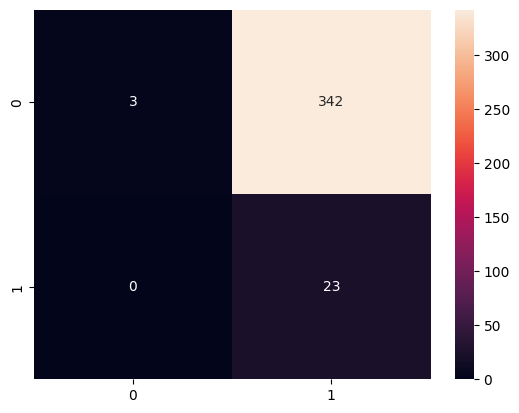

In [97]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

## Attempt 3
In my third and final attempt, I was hoping to include rows in my dataset that incorporated hits within a specified distance of the fielder.  I never got to the point where I restricted the rows based on distance.  My distance calculation was incorrect.

### Query
```
SELECT -- column list
       -- Example of retrieving JSON value
     , data->>'x' AS start_x 
FROM   event b
WHERE  b.segment_type = 'hit_data' 
AND    ( b.game_id, b.play_id ) IN ( 
    SELECT -- results of subquery 
    AND    ( ( ab.bat_side = 'L' AND m.data->>'value' = 'Extreme opposite field' ) 
    OR       ( ab.bat_side = 'R' AND m.data->>'value' IN ('Dead pull', 'Pull') ) )
);
```

In [203]:
df_main = pd.read_csv('final/207_data_202307.csv')
df_hit = pd.read_csv('final/207_hit_coords_202307.csv')

In [204]:
df_hit.head(10)

,game_id,play_id,start_x,start_y,start_z,end_x,end_y,end_z
0,717447,22c382a5-bcf9-48cc-b773-4be5091dd536,-0.978031,0.855407,2.412309,-12.970955,36.945054,0.205342
1,717381,a9640f8c-88b1-4d1d-8186-8103c3c0f1ab,0.296918,0.450454,2.966095,-148.916394,174.279421,9.952229
2,717207,09d38f1f-ea5d-4f56-913a-2b3337a68c5a,0.599885,2.782224,2.080149,-11.817916,27.729574,0.260359
3,717370,eaab31fe-1bff-4f6f-bffb-04f0248bda01,-1.009635,1.129015,2.487039,-96.401218,81.917572,7.405006
4,717541,0041aff7-a89c-43f4-9549-f7265836eeb3,-0.119757,0.782917,2.808525,-42.912755,89.636527,8.408630
5,717297,a40af10c-0400-4240-8c61-e04c43e87a55,0.108685,1.409840,2.835626,-16.051716,43.946459,0.399313
6,717489,186dc06f-47fd-4e23-bdb0-77580d20a8ec,0.523070,2.007708,2.180889,-1.659660,4.954541,0.110511
7,717372,0323b156-53f4-4d3d-8826-f3716666eee6,0.694406,0.772408,3.128848,-98.640263,37.140782,8.933544
8,717334,f6f5f37b-8d2b-4178-bf61-a3f628a143c6,0.134585,1.463013,2.044486,-8.648824,32.023703,0.493193
9,717476,766d3d1f-2170-43f3-8bf1-dc90d59acc77,0.203202,1.750648,1.907177,-3.130801,6.169033,0.102273


In [219]:
df_merged = df_main.merge(df_hit, how='inner', on=['play_id', 'game_id'])

In [220]:
df_merged.head(10)

,game_id,play_id,play_out,reached_base_on_error,error,fielding_chance,launch_angle,exit_velocity,fielder_angle,fielder_distance,...,end_player_angle,start_player_position,end_player_position,fielding_zone,start_x,start_y,start_z,end_x,end_y,end_z
0,717179,17996645-7e9d-40fa-bdca-2fe01492aa0d,1,0,0,1,-25.597094,90.593521,-131.068,18.240,...,-36.942,132.524,132.523,Back,-0.200681,1.753143,2.275740,-3.338514,4.985286,0.096516
1,717179,213f2fa4-a566-40ab-9fbc-daeb9fc80f2d,2,0,0,1,-15.819751,78.084128,135.066,58.759,...,-34.259,108.815,108.801,Standard Back,-0.697933,1.238859,2.466582,-4.379479,8.143506,0.163027
2,717179,4b32275d-b608-449e-aa80-4f5e468ff263,1,0,0,1,-14.555188,97.876350,NaN,6.198,...,-34.692,121.821,121.790,Standard Back,-0.274776,1.965357,1.935887,-4.302666,7.387323,0.142683
3,717179,4c7088d4-7f8e-4f9a-b829-1807e6d32ccc,2,0,0,1,-4.060342,102.033881,-31.363,51.528,...,-34.706,121.618,121.580,Standard Back,0.202186,3.049435,2.693414,-15.632408,23.351600,0.238215
4,717179,5e2cfe93-a0b3-422f-8247-3b83f301106e,1,0,0,1,3.354306,41.104402,-11.242,70.170,...,-27.662,113.729,113.133,Standard Back,1.317552,0.481456,2.925283,-16.076067,26.184060,0.166914
5,717179,b8c18a0f-4514-402c-a722-0ee3525118bc,1,0,0,1,-8.362124,89.873971,-12.284,16.852,...,-36.468,132.693,132.718,Back,0.233797,3.158566,2.318116,-8.962583,14.144162,0.137530
6,717179,d01ce028-9ab4-4738-85b2-cff73366946f,1,0,0,1,68.865269,88.098835,NaN,NaN,...,-40.541,132.302,138.122,Back,-0.368788,2.348281,2.980450,-89.552456,105.898095,6.335604
7,717179,fd4198db-44f2-4665-9520-203970d5c59f,1,0,0,1,-32.705682,84.560716,60.946,69.684,...,-36.702,130.953,130.948,Back,0.292295,1.895866,2.885679,-2.563941,4.941834,0.103539
8,717181,1a29f643-c615-43fb-a7da-c2fe3b9fe371,1,0,0,1,-19.309276,85.742462,-29.381,24.108,...,-34.516,114.618,114.580,Standard Back,-0.163866,1.803110,1.794387,-3.818579,4.781159,0.117549
9,717181,9c93e1e0-6045-4416-a07d-319f41dc30a7,1,0,0,1,9.823791,78.026257,96.935,26.718,...,-36.689,127.137,126.939,Standard Back,-0.184139,2.403540,2.403541,-61.171749,88.210198,0.208132


In [264]:
def fielder_distance_to_path(x, y, z, hit_angle, fielder_distance, fielder_angle):
    ball_x = x / 12
    ball_y = y / 12
    ball_z = z / 12
    
    # The fielder's position in xy plane 
    fielder_x = fielder_distance * np.cos(np.radians(fielder_angle))
    fielder_y = fielder_distance * np.sin(np.radians(fielder_angle))
    fielder_z = 0
    fielder_position = np.array([fielder_x, fielder_y, fielder_z])

    # The direction vector of the hit trajectory
    trajectory_x = ball_x + fielder_distance * np.cos(np.radians(hit_angle))  # 200 feet in x direction
    trajectory_y = ball_y + fielder_distance * np.sin(np.radians(hit_angle))  # 200 feet in y direction
    # assuming no change in z - direction
    trajectory_vector = np.array([trajectory_x, trajectory_y, ball_z])

    # The vector from the fielder to the trajectory end point
    fielder_to_trajectory_vector = fielder_position - trajectory_vector

    fig, ax = plt.subplots()

    ax.quiver(ball_x, ball_y, trajectory_vector[0] - ball_x, trajectory_vector[1] - ball_y, angles='xy', scale_units='xy', scale=1, color='b', label="trajectory")
    ax.quiver(0, 0, fielder_position[0], fielder_position[1], angles='xy', scale_units='xy', scale=1, color='r', label="fielder")
    ax.quiver(trajectory_vector[0], trajectory_vector[1], fielder_to_trajectory_vector[0], fielder_to_trajectory_vector[1], angles='xy', scale_units='xy', scale=1, color='g', label="fielder_to_trajectory")

    plt.xlim(-100, 300)
    plt.ylim(-200, 300)
    plt.grid()
    plt.legend()
    plt.show()

    # The distance from the fielder to the trajectory
    distance = np.linalg.norm(fielder_to_trajectory_vector)

    print(f"x: {ball_x}")
    print(f"y: {ball_y}")
    print(f"z: {ball_z}")
    print(f"hit angle: {hit_angle}")
    print(f"fielder distance: {fielder_distance}")
    print(f"fielder angle: {fielder_angle}")
    
    print('The shortest distance from the fielder to the ball\'s trajectory is: ', distance)
    return distance

game: 717179
play: 17996645-7e9d-40fa-bdca-2fe01492aa0d


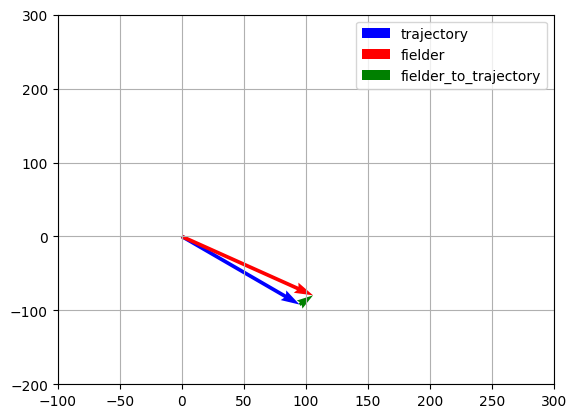

x: -0.01672337884419114
y: 0.14609521532466363
z: 0.18964501696178526
hit angle: -44.16417016620271
fielder distance: 132.523
fielder angle: -36.942
The shortest distance from the fielder to the ball's trajectory is:  16.594855444989417


16.594855444989417

In [265]:
print(f"game: {df_merged.iloc[0]['game_id']}")
print(f"play: {df_merged.iloc[0]['play_id']}")

fielder_distance_to_path(
    df_merged.iloc[0]['start_x'],
    df_merged.iloc[0]['start_y'],
    df_merged.iloc[0]['start_z'],
    -44.16417016620271,
    df_merged.iloc[0]['end_player_position'],
    df_merged.iloc[0]['end_player_angle']
)

<video width="600px" height=" " 
       src="images/9bef80fc-118e-44a9-bda4-13755b1b92b7.mp4"  
       controls>
</video>

This is a good example of how my calculation is not accurate. The distance calculated was 16 feet, but the video clearly shows the ball was hit directly to the fielder.

# Lessons Learned
My first attempts at gathering data produced 2 csv files for the entire 2023 regular season.  One file was created directly from *FIELDING* and the other from *ATBAT*.  These two datasets were used because the joining of large tables was a time consuming process.  It would take minutes for the query to start returning results, and the exporting of rows took too long.  After my initial attempts at working with the data revealed some issues with NULL values, and I realized I needed another run at exporting data, I decided to create an index on the FIELDING table, which made a significant difference in how quickly the query executed.  I also decided to scale back my dataset to only include MLB regular season games in July.

```
CREATE INDEX fielding_detail_100_idx ON analytics.fielding_detail (pitcher_sport_id, game_type_code, YEAR, fielder_position, game_id, play_id);
```

Since the first dataset contained too many NULL values, I turned my attention to a single query that retrieved data from the raw METRIC table.  I decided to reduce the overall number of rows.  While the features seemed to better all for predictions, and the column PLAY_OUT was removed to reduce the potential for overfitting, I realized I was missing a key aspect of the training set - hits.  I was initially focused on only plays that included fielding chances.  To be complete, I also need to include examples of base hits with features of the hit that resemble those when errors and outs are recorded.

# Findings for Objectives
**1) Can we create a reasonably predictive algorithm for consistently classifying errors in a baseball game using a combination of scoring details and player and ball tracking metrics?**

*Yes, I believe this is something that can be predicted with the proper combination of training data, features, and machine learning algorithm.  While I did not achieve this objective in this project.  I do see potential with further development of the training set.*

**2) Are there particular features that are more influential in determining play classification?**

*I would have liked to have been able to visualize a relationship between features and errors.  My attempts to use scatterplots did not provide a good representation.  In hindsight, I wonder a histogram that focused on error count would have provided some visualization.  Perhaps seeing the number of errors when the exit velocity was between 95-100mph, for example.  I am also curious if there is a way to combine metrics together?  Perhaps a combination of exit velocity and spin rate, for example.  These are things I will continue to investigate as my learning advances.*

**3) What types of data, if any, are going to make error predictions less accurate or less reliable?  Can those features be evaluated to determine classification probability?**

*Without finding a good way to visualize a relationship between features and the error classification, it was difficult to determine which specific columns were more or less relevant.  Some machine learning techniques provided feedback for this sort of question.  As an example, Random Forest Classifier has the 'feature importance' value that can be viewed.  I did see others had correlation options, but I would like to investigate how to better identify this type of information.*

# Future Research
In order to truly predict the correct error/no error result, I will have to produce a result set that includes both fielding chances and non-fielding chances.  Since the dataset is incomplete and the calculation to determine fielder distance did not work as expected, further data refinement is necessary.